In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [2]:
start_time = time.time()

In [3]:
asteroid_df = pd.read_csv("data/asteroid_normalized_small_df.csv")
asteroid_df

,pha,neo,H,e,q,n,moid,diameter,albedo,a,i,spkid,full_name
0,0,0,-7.411043,-0.608738,0.289176,-0.009788,0.306452,314.112492,0.088235,0.010929,0.149533,20000001,1 Ceres (A801 AA)
1,0,0,-6.932515,0.859223,-0.382876,-0.017945,-0.258065,170.929147,0.566176,0.016393,2.991822,20000002,2 Pallas (A802 FA)
2,0,0,-6.282209,1.108738,-0.618740,0.181077,-0.564516,81.471793,1.000000,-0.165756,0.429907,20000003,3 Juno (A804 RA)
3,0,0,-7.466258,-0.503883,-0.357027,0.928222,-0.403226,175.093015,2.535294,-0.728597,-0.253505,20000004,4 Vesta (A807 FA)
4,0,0,-5.171779,0.440777,-0.444265,0.384992,-0.451613,34.494963,1.441176,-0.336976,-0.461449,20000005,5 Astraea (A845 XA)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137912,0,0,-3.141104,8.195146,6.101777,-3.502333,6.048387,14.246810,-0.073529,795.153005,15.725467,3547316,(2010 BK118)
137913,0,0,-0.319018,7.751456,2.129241,-3.470979,2.258065,0.821692,-0.227941,107.539162,11.220794,3516402,(2010 GW64)
137914,0,0,-1.306748,8.038835,4.859451,-3.497338,5.290323,4.005037,-0.301471,320.107468,10.549065,3517549,(2010 GW147)
137915,0,0,-0.503067,7.960194,0.447496,-3.476215,0.903226,1.029886,-0.191176,121.236794,5.149533,3523334,(2010 JH124)


In [4]:
exclude_col = ['pha', 'spkid', 'full_name']
X = asteroid_df.drop(columns = exclude_col)
y = asteroid_df.iloc[:, 0]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 42)

# Decision Tree

In [6]:
dtree = DecisionTreeClassifier(
    class_weight=None, criterion='gini', max_depth=None,
    max_features=10, max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_split=2,  #min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, random_state=1,
    splitter='best'
)

In [7]:
#set the tree's hyperparameter grid
# Instantiate BaggingClassifier with the base estimator
bagging_dtree = BaggingClassifier(
    estimator=dtree,
    n_estimators=100,       # Number of trees in the ensemble
    max_samples=0.8,        # Fraction of samples per bootstrap sample
    max_features=10,       # features per tree
    bootstrap=True,         # Enable bootstrap sampling
    n_jobs=-2,              
    random_state=42
)

pipeline = Pipeline([
    ('bagging', bagging_dtree)
])

# Define params_dt
params_dtree = {
    'bagging__estimator__max_depth': [4, 5, 6, 7, 8, 9, 10],
    'bagging__estimator__min_samples_leaf': [0.12, 0.14, 0.16, 0.18, 0.20]
}

# performing the grid search.
grid_bagging_dtree = GridSearchCV(estimator=pipeline,
                                  param_grid=params_dtree,
                                  scoring='roc_auc',
                                  cv=5,
                                  verbose = 1,
                                  n_jobs=-2)

grid_bagging_dtree.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('bagging',
                                        BaggingClassifier(estimator=DecisionTreeClassifier(max_features=10,
                                                                                           random_state=1),
                                                          max_features=10,
                                                          max_samples=0.8,
                                                          n_estimators=100,
                                                          n_jobs=-2,
                                                          random_state=42))]),
             n_jobs=-2,
             param_grid={'bagging__estimator__max_depth': [4, 5, 6, 7, 8, 9,
                                                           10],
                         'bagging__estimator__min_samples_leaf': [0.12, 0.14,
                                                                  0.16, 0.18,
                                                                  0.2]},
             scoring='roc_auc', verbose=1)

In [8]:
# Extract the best estimator
best_bagging_model = grid_bagging_dtree.best_estimator_
print('Best estimator:\n', best_bagging_model)

# Predict the test set probabilities of the positive class
y_pred_proba = best_bagging_model.predict_proba(X_test)[:, 0]
y_pred_proba2 = best_bagging_model.predict_proba(X_test)[:, 0]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)
test_roc_auc = roc_auc_score(y_test, y_pred_proba2)
print('Test set ROC AUC score with Bagging index 0: {:.3f}'.format(test_roc_auc))
print('Test set ROC AUC score with Bagging index 1: {:.3f}'.format(test_roc_auc))

Best estimator:
 Pipeline(steps=[('bagging',
                 BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                                    max_features=10,
                                                                    min_samples_leaf=0.12,
                                                                    random_state=1),
                                   max_features=10, max_samples=0.8,
                                   n_estimators=100, n_jobs=-2,
                                   random_state=42))])
Test set ROC AUC score with Bagging index 0: 0.110
Test set ROC AUC score with Bagging index 1: 0.110


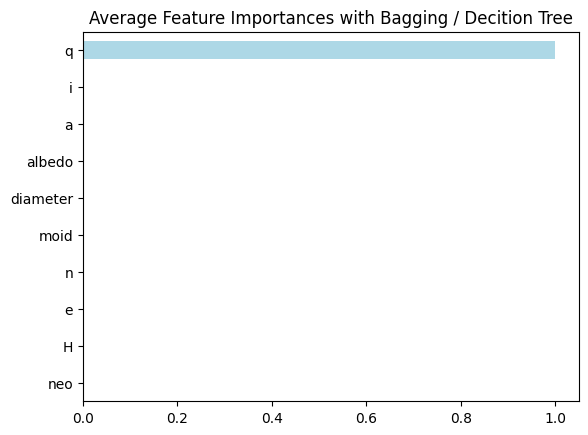

In [9]:
# Feature Importances (average across trees)
bagging_model = best_bagging_model.named_steps['bagging']

total_importances = np.zeros(X_train.shape[1])

# Sum up feature importances across all trees in the ensemble
for idx, tree in enumerate(bagging_model):
    tree_importances = tree.feature_importances_
    #print(f"Feature importances for tree {idx}: {tree_importances}")
    
    # Sum the feature importances
    total_importances += tree_importances

# Calculate the average importance across all trees
average_importances = total_importances / len(bagging_model)

# Convert to pandas Series for easy plotting
importances_series = pd.Series(data=average_importances, index=X_train.columns)

# Sort and plot
importances_sorted = importances_series.sort_values()
importances_sorted.plot(kind='barh', color='lightblue')
plt.title('Average Feature Importances with Bagging / Decition Tree')
plt.show()

# Random Forest

In [10]:
random_forest = RandomForestClassifier(
    max_samples=0.8,        
    bootstrap=True,         
    oob_score=True,
    n_jobs=-2,              
    random_state=42
)

In [11]:
# Define params_rforest
params_rforest = {
    'max_features': ['log2', 'sqrt'],
    'min_samples_leaf': [2, 10, 30],
    'n_estimators': [100, 350, 500],
}

# Instantiate grid_rf
grid_rforest = GridSearchCV(estimator=random_forest,
                       param_grid=params_rforest,
                       scoring='neg_mean_squared_error',
                       cv=3,
                       verbose=1,
                       n_jobs=-2)

grid_rforest.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(max_samples=0.8, n_jobs=-2,
                                              oob_score=True, random_state=42),
             n_jobs=-2,
             param_grid={'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [2, 10, 30],
                         'n_estimators': [100, 350, 500]},
             scoring='neg_mean_squared_error', verbose=1)

In [12]:
# Extract the best estimator
best_model_rf = grid_rforest.best_estimator_
print('Best estimator:\n', best_model_rf)

y_pred = best_model_rf.predict(X_test).astype(np.int64)

# Evaluate the test set RMSE
rmse_test = MSE(y_test, y_pred)**(1/2)

# Evaluate test set accuracy
acc_test = accuracy_score(y_test, y_pred)

# Evaluate OOB accuracy -> R2Score by default
acc_oob = best_model_rf.oob_score_

# Print acc_test and acc_oob
print('Test set accuracy: {:.2f}, OOB accuracy: {:.2f}'.format(acc_test, acc_oob))

# Print rmse_test
print('Test set RMSE of rf: {:.2f}'.format(rmse_test))

# Number of trees in best model
num_trees = len(best_model_rf.estimators_)
print("Number of trees in the random forest:", num_trees)

Best estimator:
 RandomForestClassifier(max_features='log2', max_samples=0.8, min_samples_leaf=2,
                       n_jobs=-2, oob_score=True, random_state=42)
Test set accuracy: 1.00, OOB accuracy: 1.00
Test set RMSE of rf: 0.01
Number of trees in the random forest: 100


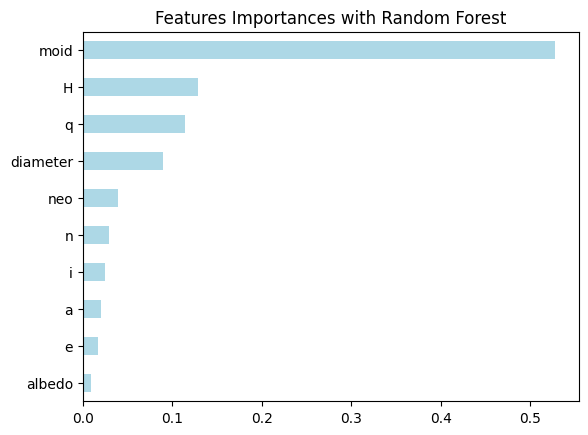

In [13]:
# Feature Importances (average across trees)
importances = pd.Series(data=best_model_rf.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(color='lightblue', kind='barh')
plt.title('Features Importances with Random Forest')
plt.show()


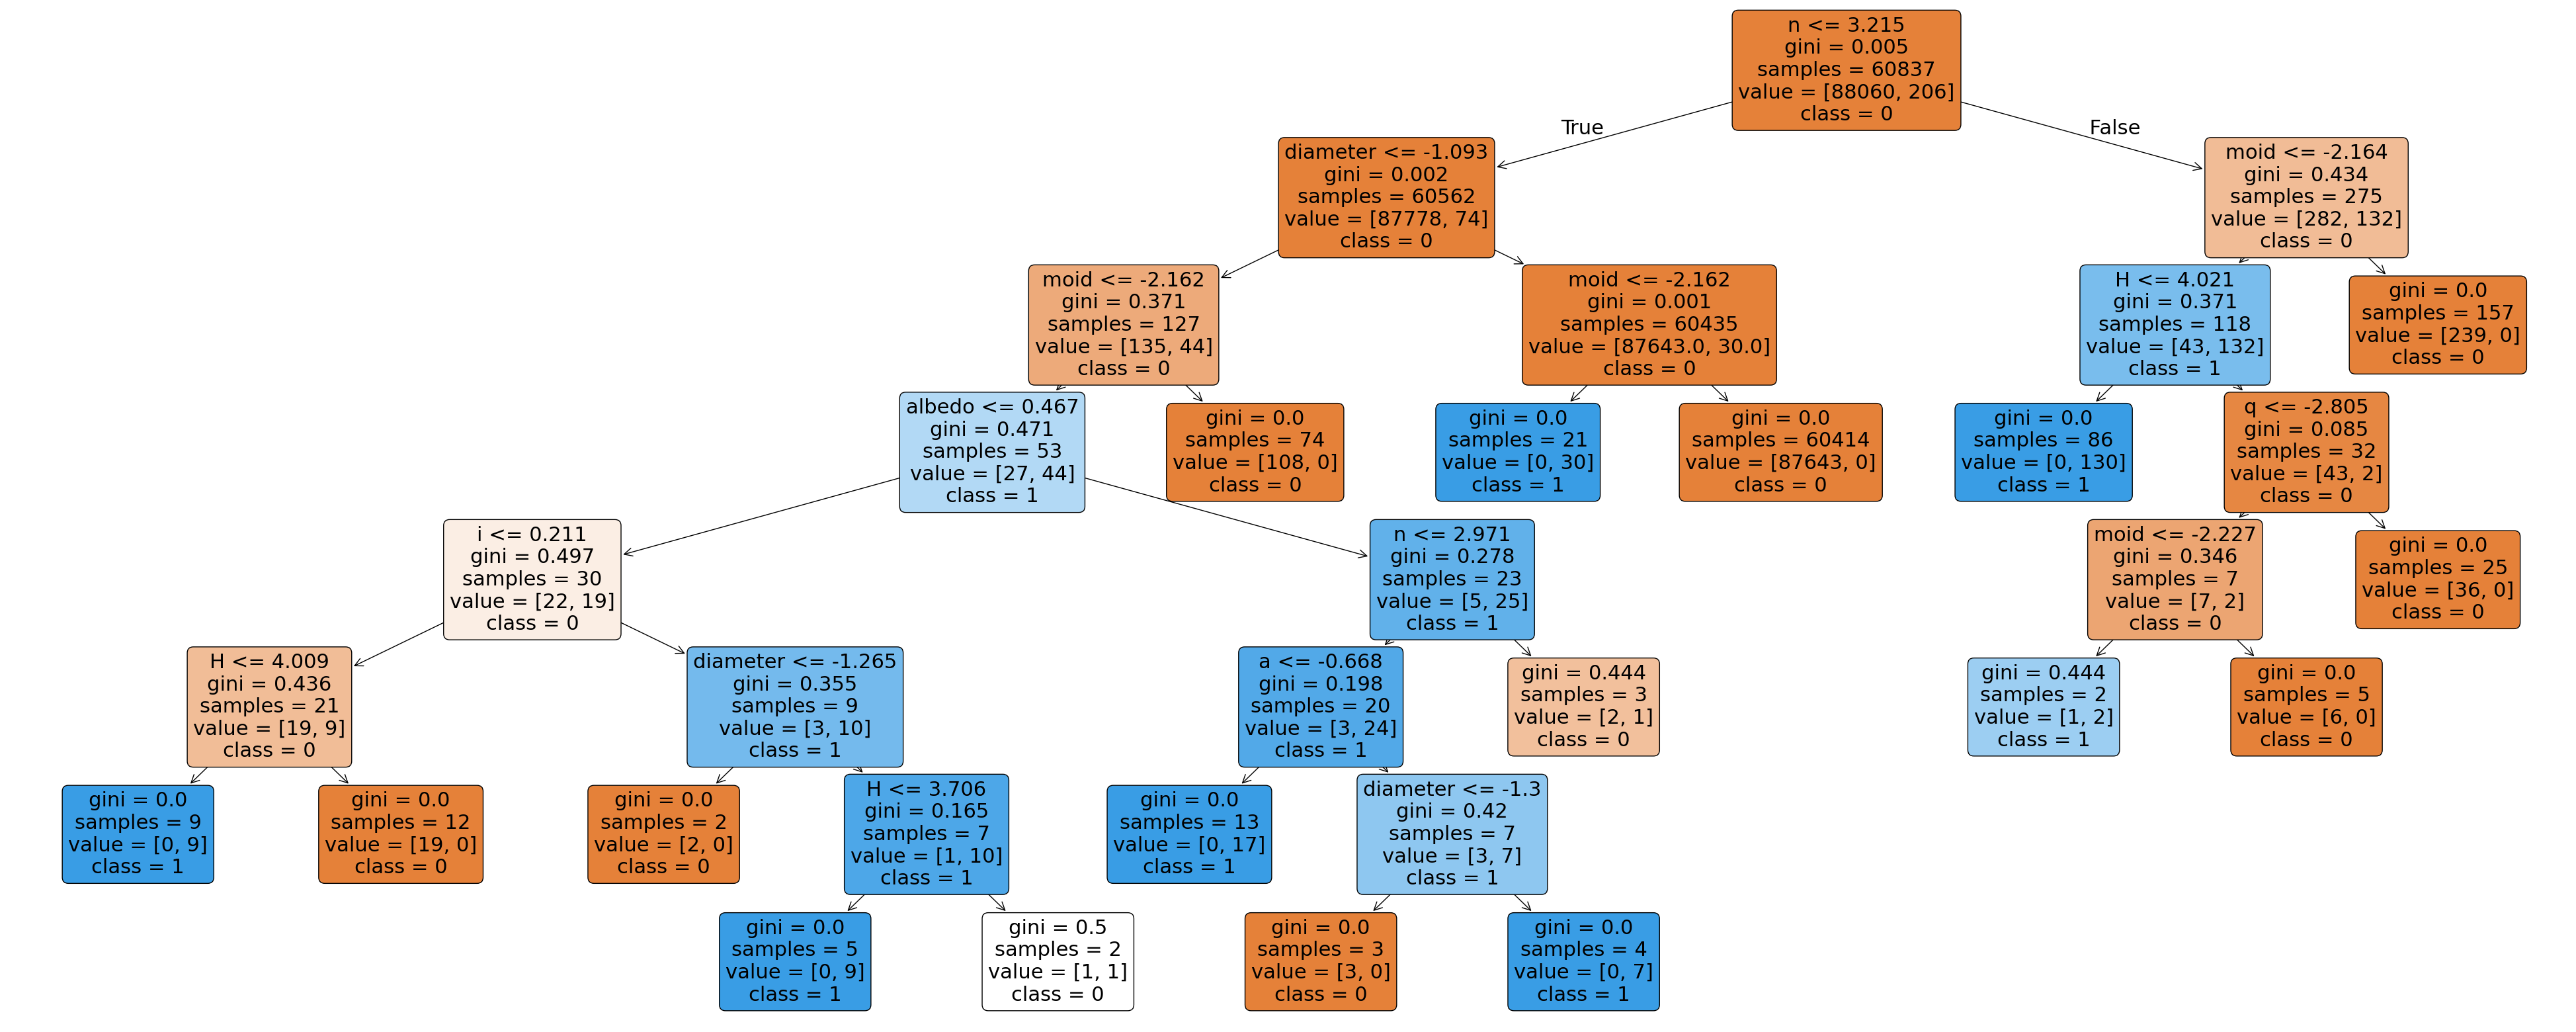

In [14]:
from sklearn import tree

tree_index = 0
individual_tree = best_model_rf.estimators_[tree_index]

fig, ax = plt.subplots(figsize=(50, 20))
tree.plot_tree(individual_tree,
              feature_names=['neo','H', 'e', 'q', 'n', 'moid', 'diameter', 'albedo', 'a', 'i'],
        class_names=['0','1'],
        rounded=True,
        filled=True,
              ax=ax)

plt.show()

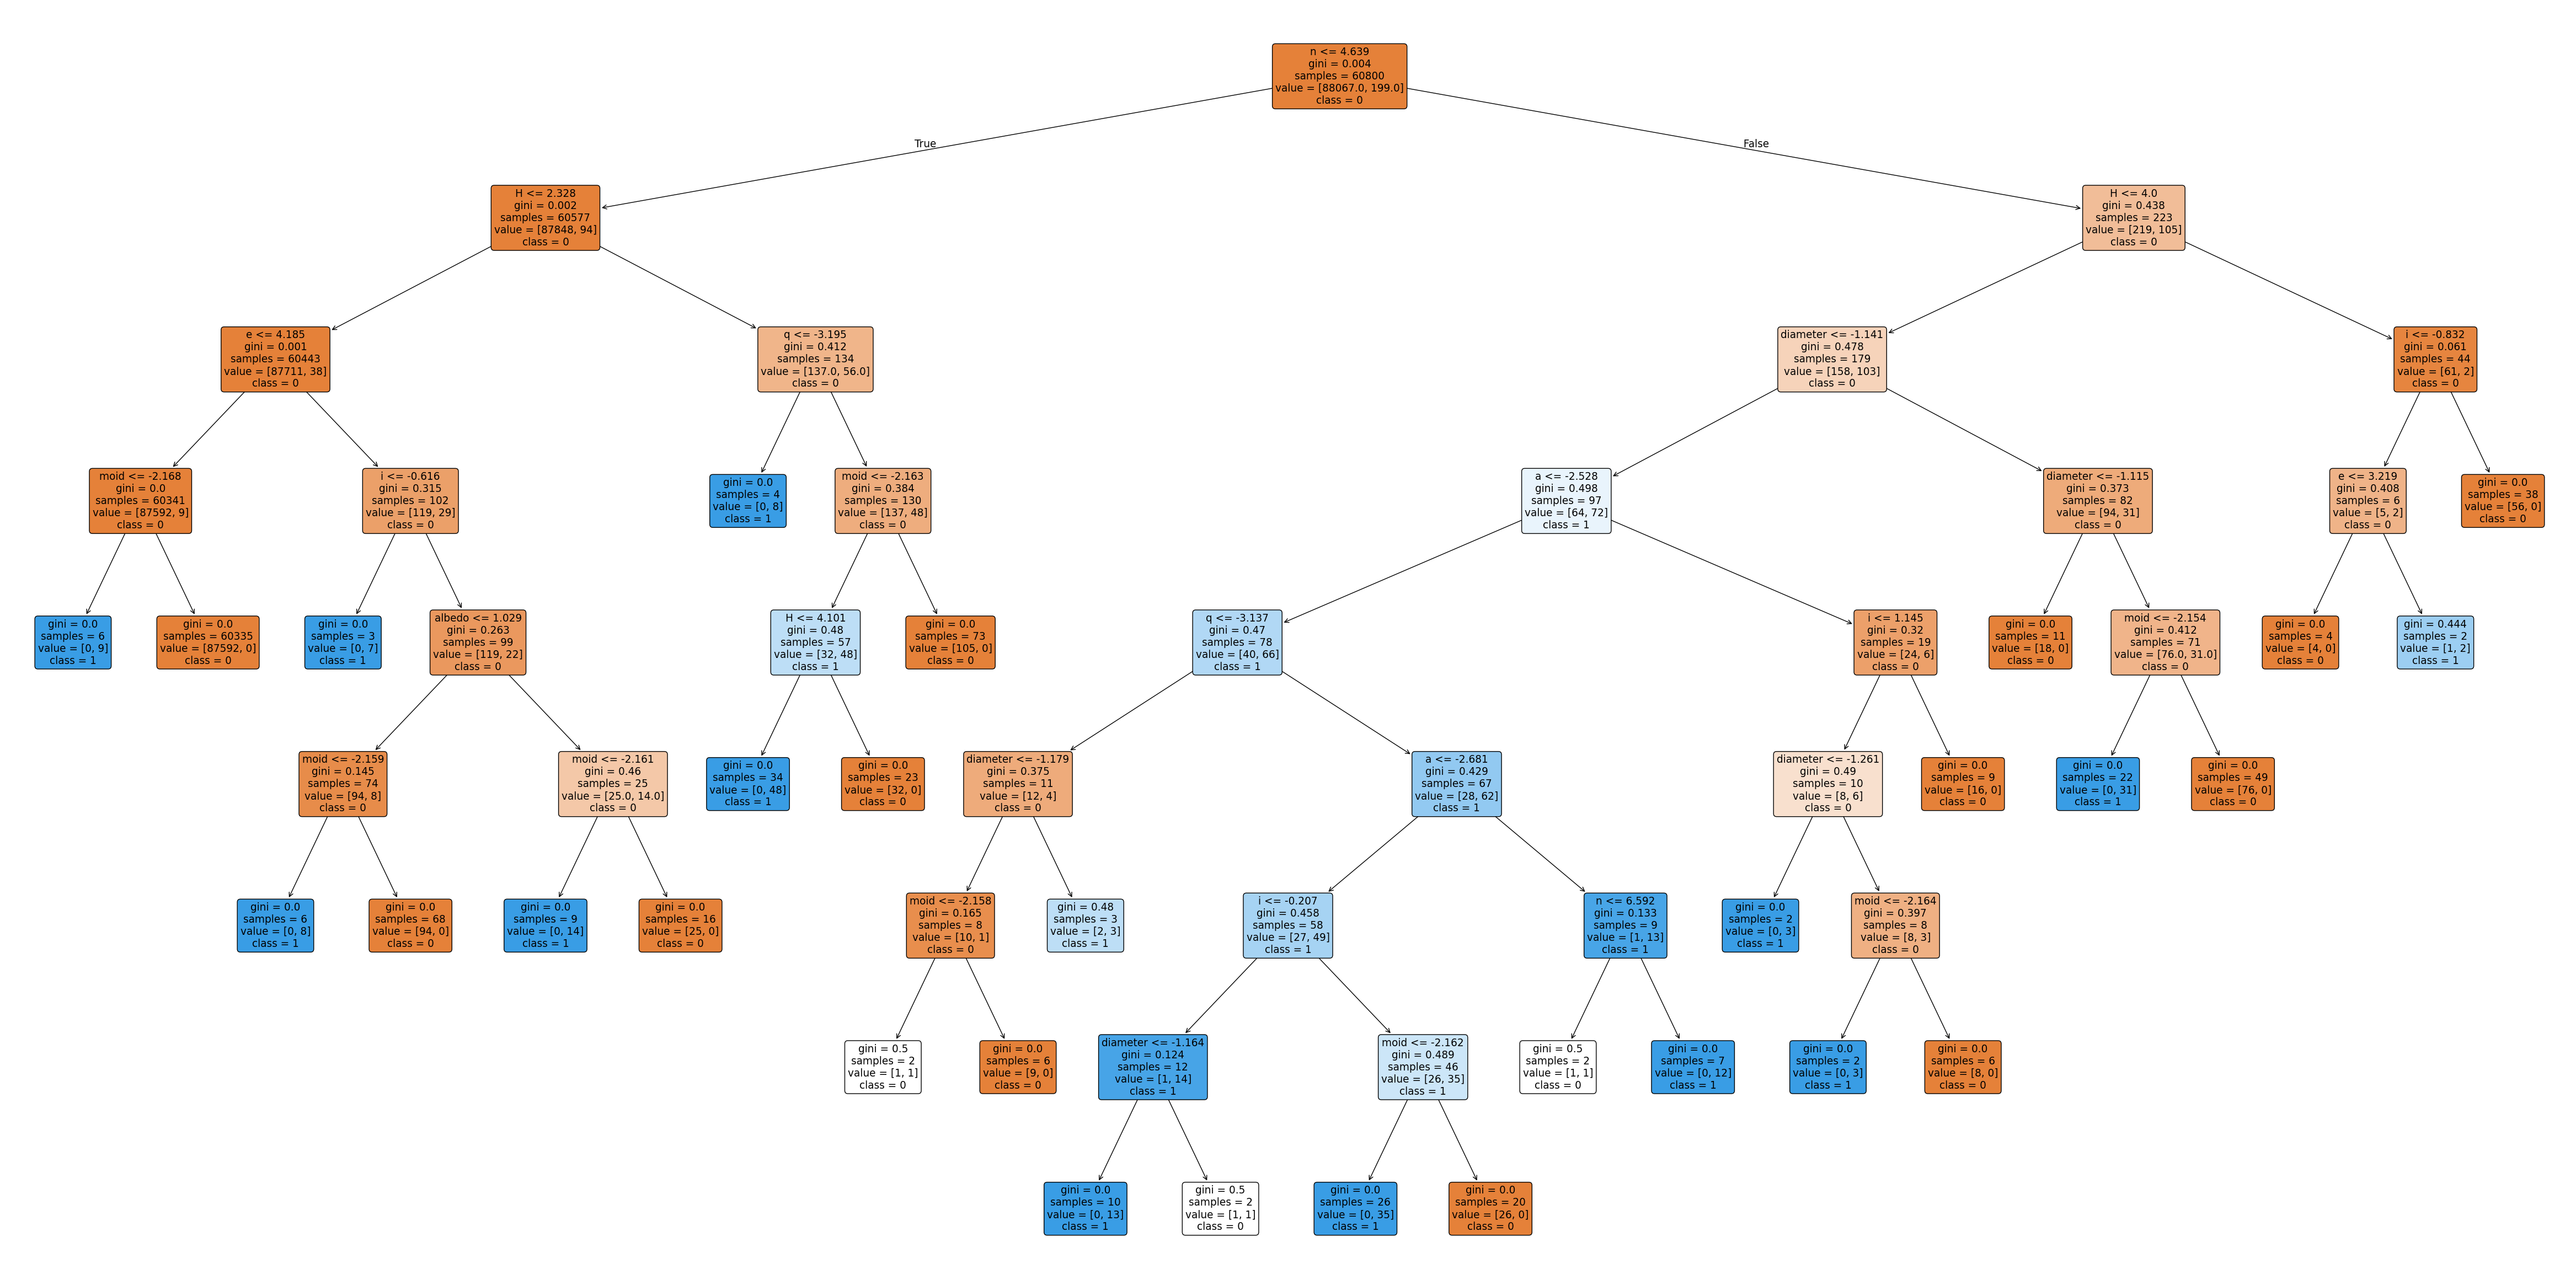

In [15]:
tree_index = 99
individual_tree = best_model_rf.estimators_[tree_index]

fig, ax = plt.subplots(figsize=(60, 30))
tree.plot_tree(individual_tree,
              feature_names=['neo','H', 'e', 'q', 'n', 'moid', 'diameter', 'albedo', 'a', 'i'],
        class_names=['0','1'],
        rounded=True,
        filled=True,
              ax=ax)

plt.show()

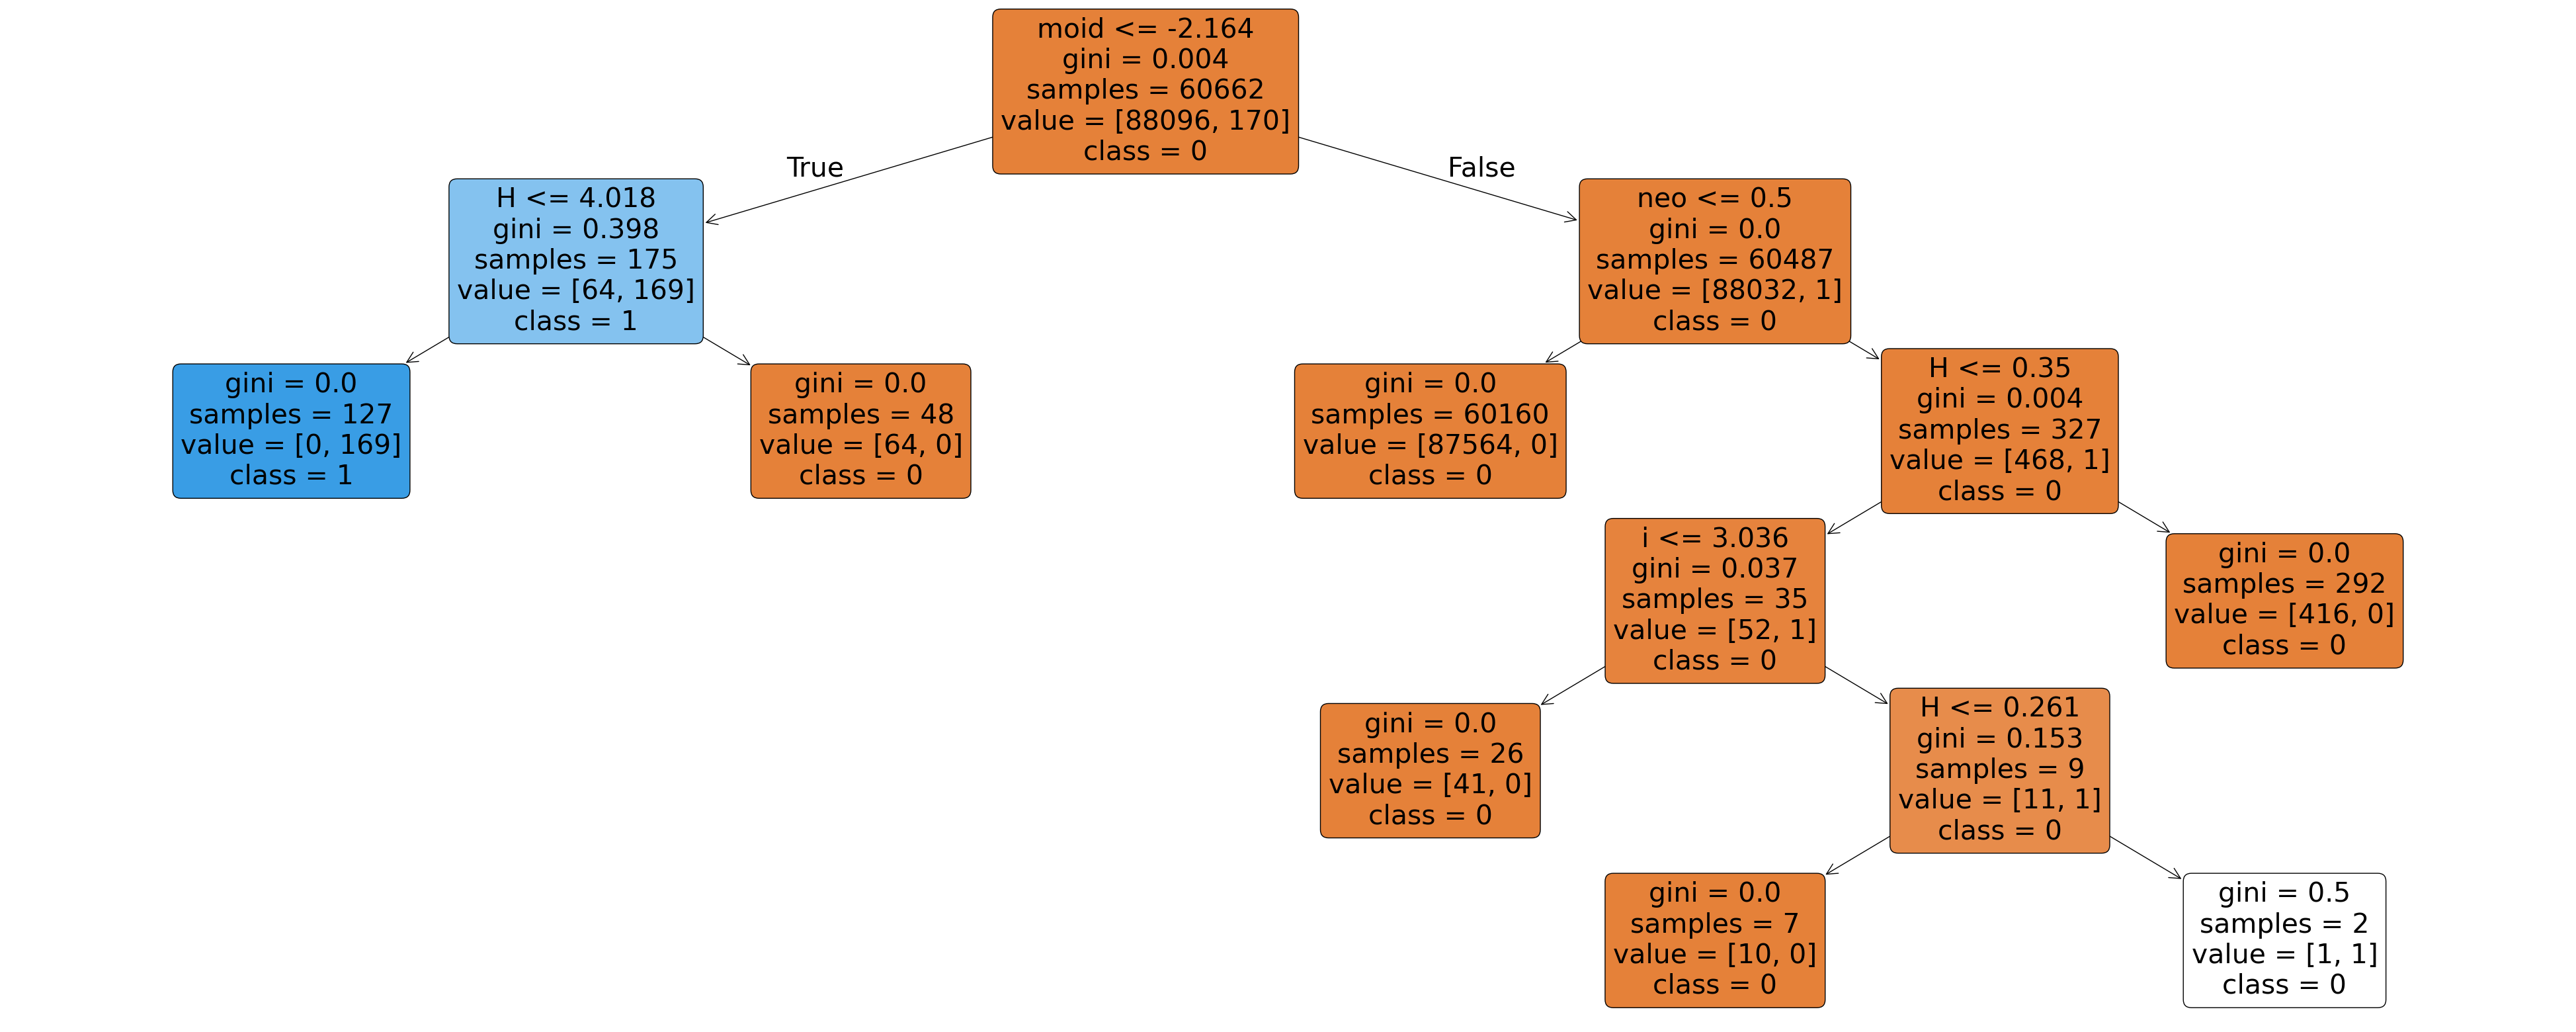

In [16]:
tree_index = 2
individual_tree = best_model_rf.estimators_[tree_index]

fig, ax = plt.subplots(figsize=(50, 20))
tree.plot_tree(individual_tree,
              feature_names=['neo','H', 'e', 'q', 'n', 'moid', 'diameter', 'albedo', 'a', 'i'],
        class_names=['0','1'],
        rounded=True,
        filled=True,
              ax=ax)

plt.show()

In [17]:
from sklearn.tree import export_text

print(export_text(individual_tree, decimals=3))

|--- feature_5 <= -2.164
|   |--- feature_1 <= 4.018
|   |   |--- class: 1.0
|   |--- feature_1 >  4.018
|   |   |--- class: 0.0
|--- feature_5 >  -2.164
|   |--- feature_0 <= 0.500
|   |   |--- class: 0.0
|   |--- feature_0 >  0.500
|   |   |--- feature_1 <= 0.350
|   |   |   |--- feature_9 <= 3.036
|   |   |   |   |--- class: 0.0
|   |   |   |--- feature_9 >  3.036
|   |   |   |   |--- feature_1 <= 0.261
|   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- feature_1 >  0.261
|   |   |   |   |   |--- class: 0.0
|   |   |--- feature_1 >  0.350
|   |   |   |--- class: 0.0



In [18]:
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 219.06 seconds
